In [79]:
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### BALANCING


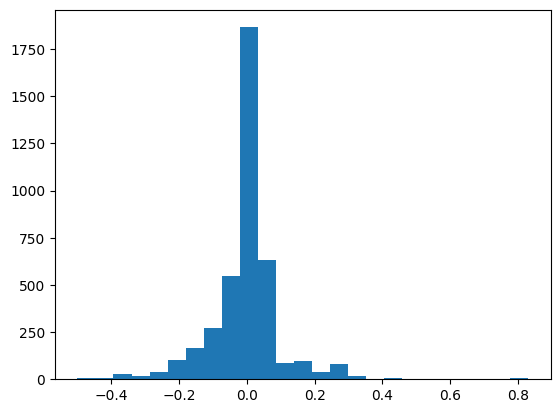

In [78]:
df = pd.read_csv("~/2025-tfg-jorge-rodriguez/carla_tests/_firstdataset/labels.csv")

plt.hist(df["steering"], bins=25)
plt.show()

In [ ]:

hist, bins = np.histogram(df["steering"], 25)

indices_to_keep = []

for i in range(25):
    bin_indices = df[
        (df["steering"] >= bins[i]) &
        (df["steering"] < bins[i+1])
    ].index.tolist()

    if len(bin_indices) > 200:
        bin_indices = np.random.choice(
            bin_indices,
            200,
            replace=False
        )

    indices_to_keep.extend(bin_indices)

df_balanced = df.loc[indices_to_keep].sample(frac=1).reset_index(drop=True)

<>:7: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:7: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
/tmp/ipykernel_3241/602722278.py:7: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  (df["steering"] >= 25[i]) &
/tmp/ipykernel_3241/602722278.py:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  (df["steering"] < 25[i+1])
/tmp/ipykernel_3241/602722278.py:7: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  (df["steering"] >= 25[i]) &
/tmp/ipykernel_3241/602722278.py:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  (df["steering"] < 25[i+1])
/tmp/ipykernel_3241/602722278.py:7: SyntaxWarning: 'int' object is not subscriptable; perh

TypeError: 'int' object is not subscriptable

### DATASET

In [65]:
class CarlaDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        self.train_data = pd.read_csv(os.path.expanduser(csv_file))
        self.dir_img = os.path.expanduser(img_dir)

        self.transform = T.Compose([
            T.Resize((66, 200)),
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):

        img_path = os.path.join(self.dir_img, self.train_data.iloc[idx]["image"])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        steering = torch.tensor(self.train_data.iloc[idx]["steering"], dtype=torch.float32)
        return img, steering

### PILOT NET STRUCTURE

In [66]:
class PilotNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ReLU(),

            nn.Conv2d(24, 36, 5, stride=2),
            nn.ReLU(),

            nn.Conv2d(36, 48, 5, stride=2),
            nn.ReLU(),

            nn.Conv2d(48, 64, 3),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 66, 200)
            n_features = self.conv(dummy).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_features, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

### TRAINING

In [67]:
dataset = CarlaDataset(
    csv_file="~/2025-tfg-jorge-rodriguez/carla_tests/_firstdataset/labels.csv",
    img_dir="~/2025-tfg-jorge-rodriguez/carla_tests/_firstdataset/images"
)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [68]:
model = PilotNet()

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Move  model to device
model = model.to(device)
print(model)

cpu
PilotNet(
  (conv): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=10, bias=True)
    (6): ReLU()
    (7): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [70]:
# Define loss function
criterion = nn.MSELoss()

# Define optimizer
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [71]:
epochs = 10

for epoch in range(epochs):
    model.train()
    loss_epoch = 0.0
    n_samples = 0

    for images, steering in loader:
        images = images.to(device)
        steering = steering.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, steering)

        loss.backward()
        optimizer.step()

        loss_epoch += loss.item() * images.size(0)
        n_samples += images.size(0)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_epoch / n_samples:.6f}")

Epoch 1/10 - Loss: 0.006807
Epoch 2/10 - Loss: 0.004439
Epoch 3/10 - Loss: 0.003871
Epoch 4/10 - Loss: 0.003345
Epoch 5/10 - Loss: 0.002983
Epoch 6/10 - Loss: 0.002562
Epoch 7/10 - Loss: 0.002360
Epoch 8/10 - Loss: 0.002208
Epoch 9/10 - Loss: 0.002214
Epoch 10/10 - Loss: 0.002178
